In [2]:
%matplotlib notebook

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time
import os
from os.path import join
import re

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [3]:
start_path = '/Users/s3182541/STSP/Decoding/data/final/exp1'
mod1_pat = re.compile(r"c1")
mod2_pat = re.compile(r"c2")

In [6]:
c1s = []
c2s = []

status = dict()

for root, dirs, files in os.walk(start_path):
    c1 = None
    c2 = None
    for file in files:
        _, dir = os.path.split(root)
        if not dir in status:
            status[dir] = dict()
        
        try:
            if mod1_pat.search(file):
                _c1 = np.load(join(root, file))
                if c1 is None:
                    c1 = _c1
                    status[dir][1] = 1
                else:
                    c1 = (c1 + _c1) / 2
                    status[dir][1] = 2

            if mod2_pat.search(file):
                _c2 = np.load(join(root, file))
                if c2 is None:
                    c2 = _c2
                    status[dir][2] = 1
                else:
                    c2 = (c2 + _c2) / 2
                    status[dir][2] = 2
        except ValueError as e:
            print("Error for " + join(root, file))
            print(str(e))
            continue
    
    if not c1 is None:
        c1s.append(c1)
    
    if not c2 is None:
        c2s.append(c2)
        
print(status)

c1s = np.array(c1s)
c2s = np.array(c2s)

{'7': {2: 2, 1: 2}, '18': {2: 2, 1: 2}, '12': {2: 2, 1: 2}, '15': {2: 2, 1: 2}, '4': {1: 2, 2: 2}, '11': {2: 2, 1: 2}, '16': {2: 2, 1: 2}, '3': {2: 2, 1: 2}, '9': {2: 2, 1: 2}, '1': {1: 2, 2: 2}, '14': {1: 2, 2: 2}, '13': {2: 2, 1: 2}, '19': {2: 2, 1: 2}, '6': {1: 2, 2: 2}, '8': {1: 2, 2: 2}, '2': {1: 2, 2: 2}, '17': {2: 2, 1: 2}, '10': {1: 2, 2: 2}, '5': {1: 2, 2: 2}}


In [ ]:
print(len(c1s))

In [ ]:
c1_all = c1s.mean(0)
c2_all = c2s.mean(0)

In [6]:
c_all = (c1_all + c2_all) / 2

## Experiment 1

<IPython.core.display.Javascript object>


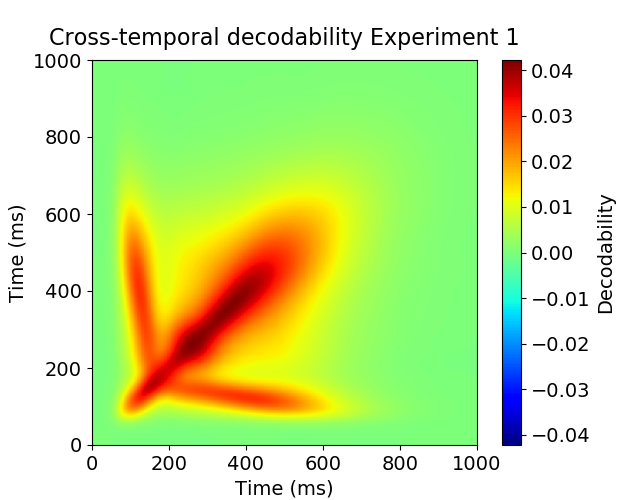

In [11]:
plt.close()

fig = plt.figure(figsize=[6.4, 5.0])

ax = fig.add_subplot(111)

ax.set_title("Cross-temporal decodability Experiment 1", pad=11)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Time (ms)")

c1 = gaussian_filter((c_all+c_all.T)/2, sigma=8)
vmax = np.max(c1)

extents = [0, 1000, 0, 1000]
im = ax.imshow(
    c1, 
    cmap='jet', 
    origin='lower', 
    extent=extents,
    vmin=-vmax,
    vmax=vmax)

fig.colorbar(im, label="Decodability")

<IPython.core.display.Javascript object>


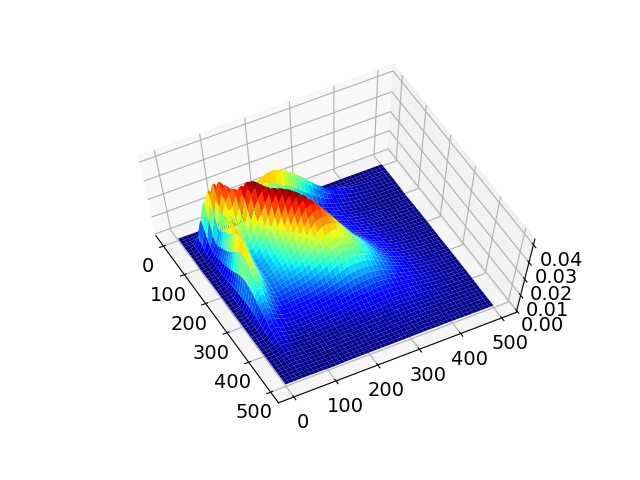

In [16]:
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = range(0, 500)
y = range(0, 500)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, c1, cmap='jet')

In [8]:
np.save('figures/data/cross_exp1.npy', c1)

In [9]:
wolff_path = '/Users/s3182541/STSP/Decoding/data/wolff'
c_exp1 = np.load(join(wolff_path, 'c_exp1.npy'))
time_exp1 = np.load(join(wolff_path, 'time_exp1.npy'))

num_include = len(time_exp1[time_exp1 >= 0.0])
c_exp1 = c_exp1[-num_include:, -num_include:]

f = scipy.interpolate.RectBivariateSpline(np.arange(c_all.shape[0]), np.arange(c_all.shape[1]), c_all)

w_steps = c_exp1.shape[0]

steps = np.linspace(0, c_exp1.shape[0], w_steps) # c_exp1.shape[0] > c_all.shape[0]
c_sparse = f(steps, steps)

z = (c_sparse - c_sparse.mean()) / c_sparse.std()
z = gaussian_filter((z + z.T)/2, sigma=8)

z_exp1 = (c_exp1 - c_exp1.mean()) / c_exp1.std()

<IPython.core.display.Javascript object>


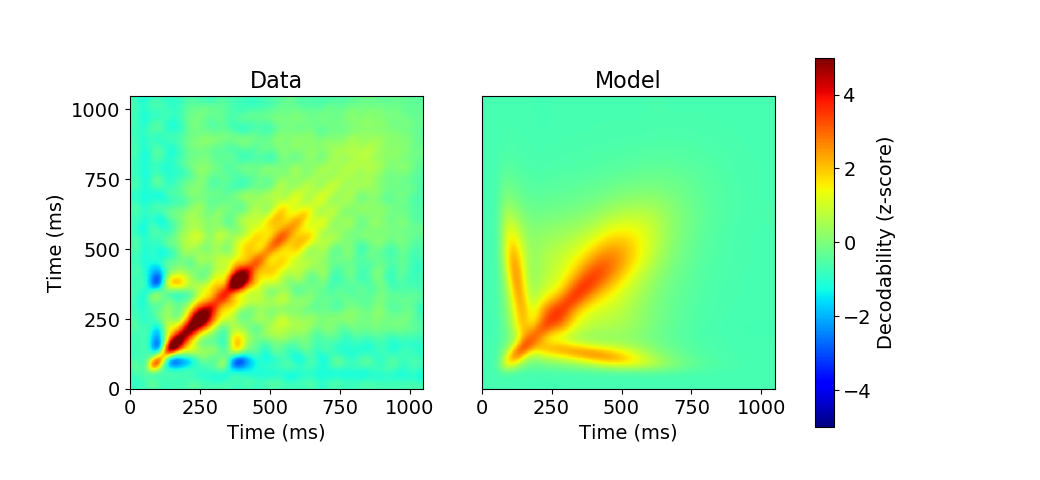

In [10]:
plt.close()

fig = plt.figure(figsize=[10.4, 4.8])

extent = [0, time_exp1[-1]*1000, 0, time_exp1[-1]*1000]
vmax = 5
vmin = -vmax

ax0 = fig.add_subplot(121)

ax0.set_title("Data")

plt.xlabel("Time (ms)")
plt.ylabel("Time (ms)")
plt.yticks([0, 250, 500, 750, 1000])

ax0.imshow(z_exp1, cmap='jet', origin='lower', extent=extent, vmin=vmin, vmax=vmax)

ax1 = fig.add_subplot(122)

ax1.set_title("Model")

plt.xlabel("Time (ms)")
plt.yticks([])

im = ax1.imshow(z, cmap='jet', origin='lower', extent=extent, vmin=vmin, vmax=vmax)

plt.colorbar(im, ax=[ax0, ax1], label="Decodability (z-score)")

In [11]:
np.save('figures/data/z_exp1.npy', z)
np.save('figures/data/z_exp1_wolff.npy', z_exp1)

## Experiment 2

<IPython.core.display.Javascript object>


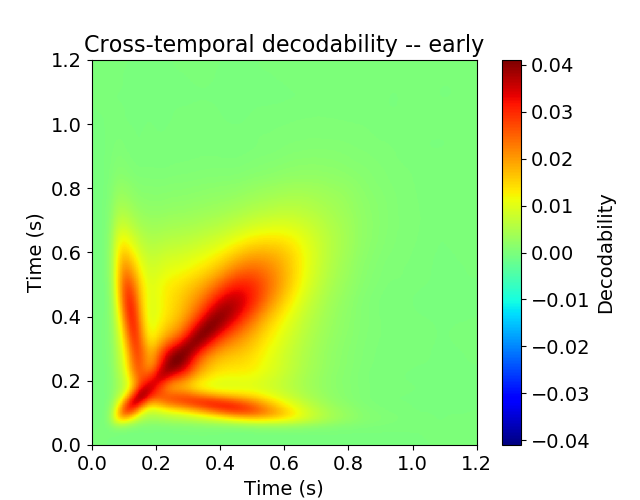

In [18]:
plt.close()

fig = plt.figure(figsize=[6.4, 5.0])

ax = fig.add_subplot(111)

ax.set_title("Cross-temporal decodability -- early")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Time (s)")

c1 = gaussian_filter((c1_all+c1_all.T)/2, sigma=8)
vmax = np.max(c1)

extents = [0, 1.2, 0, 1.2]
im = ax.imshow(
    c1, 
    cmap='jet', 
    origin='lower', 
    extent=extents,
    vmin=-vmax,
    vmax=vmax)

fig.colorbar(im, label="Decodability")

In [17]:
np.save('figures/data/cross_exp2_early.npy', c1)

<IPython.core.display.Javascript object>


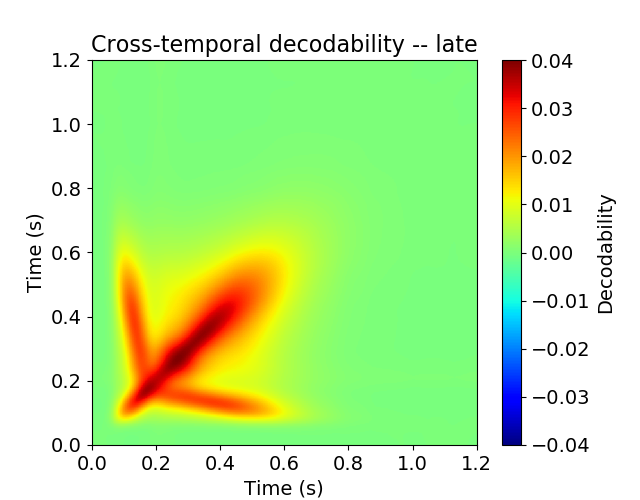

In [19]:
plt.close()

fig = plt.figure(figsize=[6.4, 5.0])

ax = fig.add_subplot(111)

ax.set_title("Cross-temporal decodability -- late")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Time (s)")

c2 = gaussian_filter((c2_all+c2_all.T)/2, sigma=8)
vmax = np.max(c2)

extents = [0, 1.2, 0, 1.2]
im = ax.imshow(
    c2, 
    cmap='jet', 
    origin='lower', 
    extent=extents,
    vmin=-vmax,
    vmax=vmax)

fig.colorbar(im, label="Decodability")

In [19]:
np.save('figures/data/cross_exp2_late.npy', c2)

## Comparison of exp 2 to Wolff

In [20]:
wolff_path = '/Users/s3182541/STSP/Decoding/data/wolff'
c_early = np.load(join(wolff_path, 'c_early.npy'))
c_late = np.load(join(wolff_path, 'c_late.npy'))
time_wolff = np.load(join(wolff_path, 'time_wolff.npy'))

num_include = len(time_wolff[time_wolff >= 0.0])
c_early = c_early[-num_include:, -num_include:]
c_late = c_late[-num_include:, -num_include:]

f1 = scipy.interpolate.RectBivariateSpline(np.arange(c1_all.shape[0]), np.arange(c1_all.shape[1]), c1_all)
f2 = scipy.interpolate.RectBivariateSpline(np.arange(c2_all.shape[0]), np.arange(c2_all.shape[1]), c2_all)

w_steps = c_early.shape[0]

steps = np.linspace(0, c1_all.shape[0], w_steps) # From 0 to end of c with w_steps number of steps
c1_sparse = f1(steps, steps)

steps = np.linspace(0, c2_all.shape[0], w_steps) # From 0 to end of c with w_steps number of steps
c2_sparse = f2(steps, steps)

cat = np.concatenate((c1_sparse, c2_sparse), axis=0)
model_std = cat.std()
model_mean = cat.mean()

z1 = (c1_sparse - model_mean) / model_std
z1 = gaussian_filter((z1 + z1.T)/2, sigma=8)

z2 = (c2_sparse - model_mean) / model_std
z2 = gaussian_filter((z2 + z2.T)/2, sigma=8)

cat = np.concatenate((c_early, c_late), axis=0)
wolff_std = cat.std()
wolff_mean = cat.mean()

z_early = (c_early - wolff_mean) / wolff_std
z_late = (c_late - wolff_mean) / wolff_std

<IPython.core.display.Javascript object>


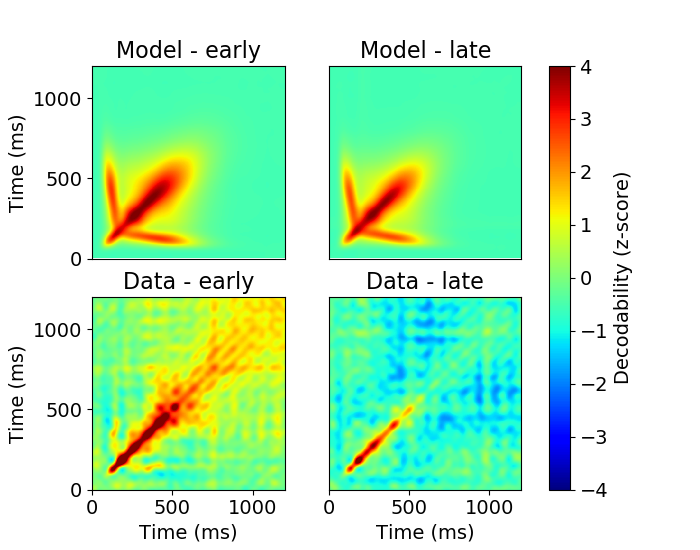

In [21]:
plt.close()

cmap = 'jet'
# vmin = min([np.min(z) for z in [z1, z2, z_early, z_late]])
# vmax = max([np.max(z) for z in [z1, z2, z_early, z_late]])
vmin = -4
vmax = 4
extent = [0, 1200, 0, 1200]

fig = plt.figure(figsize=[7.0, 5.5])

ax0 = fig.add_subplot(221)

ax0.set_title("Model - early")

plt.xticks([])
plt.ylabel("Time (ms)")

ax0.imshow(z1, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=extent)

ax1 = fig.add_subplot(222)

ax1.set_title("Model - late")

plt.xticks([])
plt.yticks([])

ax1.imshow(z2, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=extent)

ax2 = fig.add_subplot(223)

ax2.set_title("Data - early")
ax2.imshow(z_early, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=extent)

plt.xlabel("Time (ms)")
plt.ylabel("Time (ms)")

ax3 = fig.add_subplot(224)

ax3.set_title("Data - late")

plt.xlabel("Time (ms)")
plt.yticks([])

im = ax3.imshow(z_late, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=extent)

fig.colorbar(im, ax=[ax0, ax1, ax2, ax3], label="Decodability (z-score)")

In [22]:
np.save('figures/data/z_exp2_early.npy', z1)
np.save('figures/data/z_exp2_late.npy', z2)
np.save('figures/data/z_exp2_early_wolff.npy', z_early)
np.save('figures/data/z_exp2_late_wolff.npy', z_late)

<IPython.core.display.Javascript object>


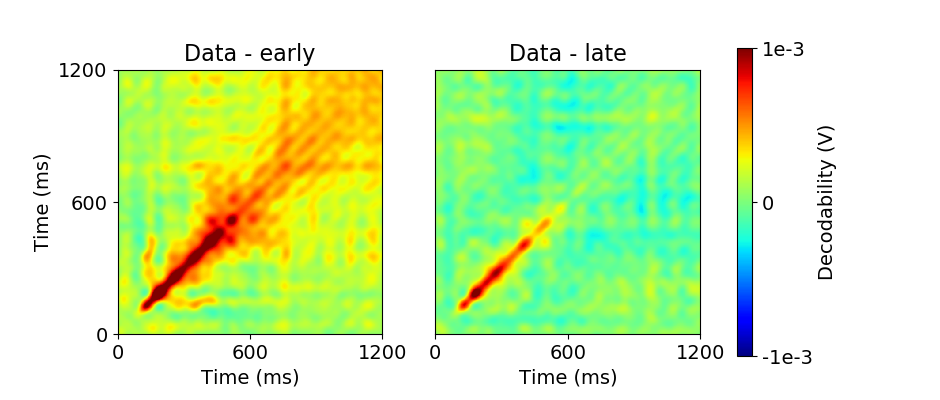

In [23]:
plt.close()

extent = [0, 1200, 0, 1200]

fig = plt.figure(figsize=[9.4, 4.0])

ax0 = fig.add_subplot(121)

plt.xlabel("Time (ms)")
plt.xticks([0, 600, 1200])
plt.ylabel("Time (ms)")
plt.yticks([0, 600, 1200])
plt.title("Data - early")

ax0.imshow(c_early, cmap='jet', origin='lower', vmin=-1e-3, vmax=1e-3, extent=extent)

ax1 = fig.add_subplot(122)

plt.xlabel("Time (ms)")
plt.xticks([0, 600, 1200])
plt.yticks([])
plt.title("Data - late")

im = ax1.imshow(c_late, cmap='jet', origin='lower', vmin=-1e-3, vmax=1e-3, extent=extent)

bar = fig.colorbar(im, ax=[ax0, ax1], label="Decodability (V)")
bar.set_ticks([-1e-3, 0, 1e-3])
bar.set_ticklabels(["-1e-3", "0", "1e-3"])

<IPython.core.display.Javascript object>


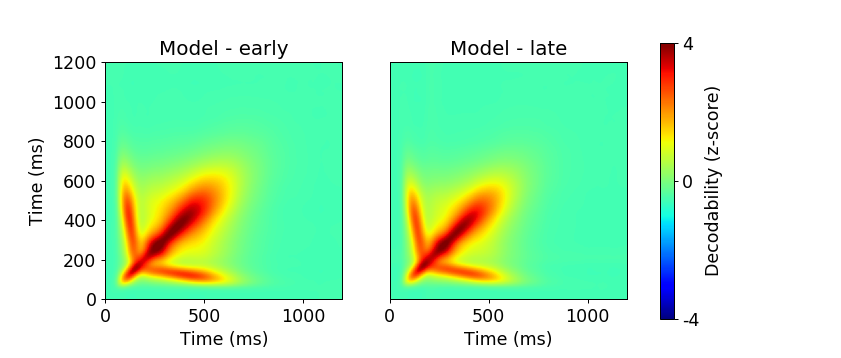

In [46]:
plt.close()

extent = [0, 1200, 0, 1200]

fig = plt.figure(figsize=[9.4, 4.0])

ax0 = fig.add_subplot(121)

plt.xlabel("Time (ms)")
plt.ylabel("Time (ms)")
plt.title("Model - early")

ax0.imshow(z1, cmap='jet', origin='lower', vmin=-4, vmax=4, extent=extent)

ax1 = fig.add_subplot(122)

plt.xlabel("Time (ms)")
plt.yticks([])
plt.title("Model - late")

im = ax1.imshow(z2, cmap='jet', origin='lower', vmin=-4, vmax=4, extent=extent)

bar = fig.colorbar(im, ax=[ax0, ax1], label="Decodability (z-score)")
bar.set_ticks([-4, 0, 4])
bar.set_ticklabels(["-4", "0", "4"])

## Normal decodability exp 1

In [4]:
cos_amps1 = []
cos_amps2 = []

for _folder in range(1, 31):
    folder = str(_folder)
    print("Doing " + folder)
    
    path = join(start_path, folder)
    file1 = join(path, "cos_amp1.npy")
    file2 = join(path, "cos_amp2.npy")
    
    cos_amp1 = np.load(file1)
    cos_amp2 = np.load(file2)
    
#     cos_amp1 = gaussian_filter(cos_amp1, sigma=8)
#     cos_amp2 = gaussian_filter(cos_amp2, sigma=8)
    
    cos_amps1.append(cos_amp1)
    cos_amps2.append(cos_amp2)

cos_amp_all = np.array(cos_amps1 + cos_amps2).mean(0)
cos_amp_all = gaussian_filter(cos_amp_all, sigma=8)
    
cos_amp_cued = np.array(cos_amps1).mean(0)
cos_amp_cued = gaussian_filter(cos_amp_cued, sigma=8)

cos_amp_uncued = np.array(cos_amps2).mean(0)
cos_amp_uncued = gaussian_filter(cos_amp_uncued, sigma=8)

Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19
Doing 20
Doing 21
Doing 22
Doing 23
Doing 24
Doing 25
Doing 26
Doing 27
Doing 28
Doing 29
Doing 30


In [8]:
np.save('figures/data/decodability_c_exp1.npy', cos_amp_all)
np.save('figures/data/decodability_c_cued.npy', cos_amp_cued)
np.save('figures/data/decodability_c_uncued.npy', cos_amp_uncued)

<IPython.core.display.Javascript object>


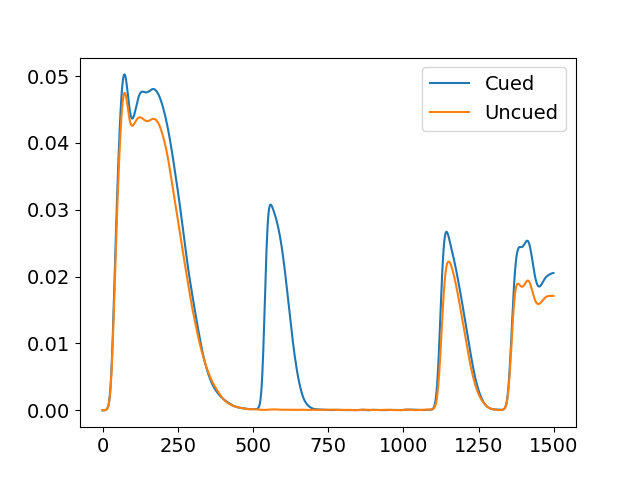

In [5]:
plt.close()

plt.plot(cos_amp_cued, label="Cued")
plt.plot(cos_amp_uncued, label="Uncued")
plt.legend()

In [26]:
z_amp = (cos_amp_all - cos_amp_all.mean()) / cos_amp_all.std()

<IPython.core.display.Javascript object>


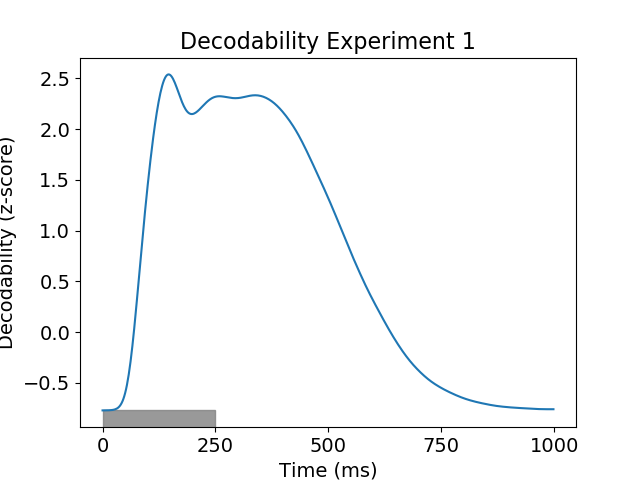

In [31]:
plt.close()

fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_title("Decodability Experiment 1")

plt.ylabel("Decodability (z-score)")
plt.xlabel("Time (ms)")

plt.xticks([0, 125, 250, 375, 500], [0, 250, 500, 750, 1000])

ax.plot(z_amp[:500])

rect = mpl.patches.Rectangle((0, -1), 125, z_amp[0]+1, color='gray', alpha=0.8)
ax.add_patch(rect)

plt.show()

In [32]:
np.save('figures/data/decodability_z_exp1.npy', z_amp)

In [34]:
cat_mean = np.concatenate((cos_amp_cued, cos_amp_uncued), axis=0).mean()
cat_std = np.concatenate((cos_amp_cued, cos_amp_uncued), axis=0).std()

z_amp_cued = (cos_amp_cued - cat_mean) / cat_std
z_amp_uncued = (cos_amp_uncued - cat_mean) / cat_std
np.save('figures/data/decodability_z_cued.npy', z_amp_cued)
np.save('figures/data/decodability_z_uncued.npy', z_amp_uncued)

## Normal decodability exp 2

In [7]:
cos_amps1 = []
cos_amps2 = []

for _folder in range(1, 20):
    folder = str(_folder)
    print("Doing " + folder)
    
    path = join(start_path, folder)
    file1 = join(path, "cos_amp1.npy")
    file2 = join(path, "cos_amp2.npy")
    
    cos_amp1 = np.load(file1)
    cos_amp2 = np.load(file2)
    
#     cos_amp1 = gaussian_filter(cos_amp1, sigma=8)
#     cos_amp2 = gaussian_filter(cos_amp2, sigma=8)
    
    cos_amps1.append(cos_amp1)
    cos_amps2.append(cos_amp2)

cos_amp_all = np.array(cos_amps1 + cos_amps2).mean(0)
cos_amp_all = gaussian_filter(cos_amp_all, sigma=8)
    
cos_amp_early = np.array(cos_amps1).mean(0)
cos_amp_early = gaussian_filter(cos_amp_early, sigma=8)

cos_amp_late = np.array(cos_amps2).mean(0)
cos_amp_late = gaussian_filter(cos_amp_late, sigma=8)

Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19


In [9]:
np.save('figures/data/decodability_c_early.npy', cos_amp_early)
np.save('figures/data/decodability_c_late.npy', cos_amp_late)

<IPython.core.display.Javascript object>


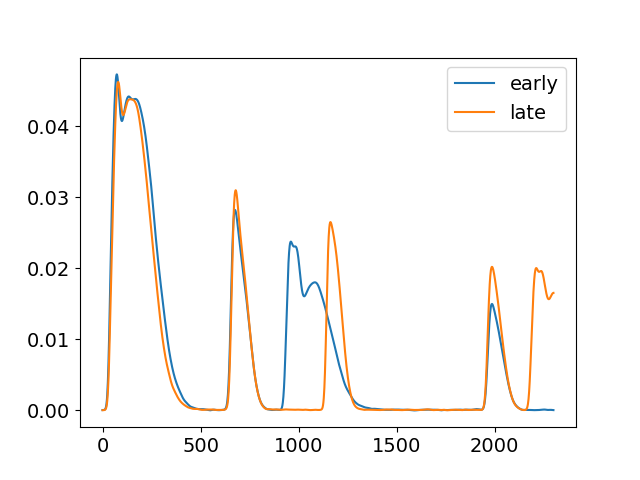

In [8]:
plt.close()

plt.plot(cos_amp_early, label='early')
plt.plot(cos_amp_late, label='late')
plt.legend()

In [11]:
cat_mean = np.concatenate((cos_amp_early, cos_amp_late), axis=0).mean()
cat_std = np.concatenate((cos_amp_early, cos_amp_late), axis=0).std()

z_early = (cos_amp_early - cat_mean) / cat_std
z_late = (cos_amp_late - cat_mean) / cat_std

In [12]:
np.save('figures/data/decodability_z_early.npy', z_early)
np.save('figures/data/decodability_z_late.npy', z_late)